In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, vstack
from astropy.wcs import WCS

import os
from os import getpid

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, Rectangle

from matplotlib.lines import Line2D

import xspec as x

import matplotlib
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec

from scipy import stats
from scipy.optimize import curve_fit

from tqdm.autonotebook import tqdm

import multiprocessing
import datetime

import scipy.odr as odr

from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel, Tophat2DKernel
from IPython.display import clear_output

/tmp/ipykernel_58677/3202773982.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Catalogues of clusters and photon lists:

In [91]:
clusters_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/cluster.dat", sep='\s+', header=0)
clusters = clusters_all[clusters_all["M500"]>1e14]
clusters = clusters[clusters["flag"]==0]

wd = "../data/eROSITA_30.0x30.0/Phox/"
mylist = sorted(os.listdir(wd))

phlists = [item for item in mylist if item[:6] == "phlist"]

print(phlists)

phlists_redshifts = [fits.open(wd+item)[0].header["REDSHIFT"] for item in phlists]#[::-1]

print(phlists_redshifts)

clusters

['phlist_124.fits', 'phlist_128.fits', 'phlist_132.fits', 'phlist_136.fits', 'phlist_140.fits']
[0.174192889973847, 0.13708140389145, 0.101142861718869, 0.0663401914452304, 0.032637492755919]


,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
171,110,0.970969,0.479718,0.014316,0.004703,2.432930e+14,0.157249,0.157891,1.366960e+14,688.128,4.470500e+12,1.209540e+13,2.44633,0.707698,0.000003,2.049620e+14,1068.920,0
187,163,0.388924,0.570999,0.016006,0.004675,2.390080e+14,0.157312,0.159659,1.126680e+14,645.187,2.896080e+12,1.061830e+13,2.43074,0.532571,0.000003,2.049290e+14,1068.880,0
350,77,0.380183,0.570491,0.033800,0.005197,3.282700e+14,0.157977,0.157810,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.515690,0.000005,2.887220e+14,1198.270,0
820,68,0.735543,0.863489,0.086085,0.005228,3.341870e+14,0.159935,0.160192,1.800240e+14,754.271,6.340420e+12,1.596800e+13,3.57076,0.972861,0.000004,2.724390e+14,1175.290,0
1245,111,0.804864,0.355207,0.133510,0.004668,2.379170e+14,0.161713,0.161111,1.321030e+14,680.349,4.667490e+12,9.869480e+12,2.78095,0.452088,0.000003,1.944720e+14,1050.360,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,113,0.839159,0.495644,0.394607,0.011199,2.242680e+14,0.063945,0.063977,1.184480e+14,615.838,2.883010e+12,1.160680e+13,2.22808,0.537683,0.000002,1.889120e+14,976.536,0
18610,199,0.149218,0.307198,0.406194,0.011455,2.400200e+14,0.064342,0.064928,1.282700e+14,632.408,3.427130e+12,1.130680e+13,2.26553,0.455429,0.000002,1.935300e+14,984.440,0
19523,349,0.373303,0.943536,0.987909,0.010375,1.783400e+14,0.084342,0.084015,1.055570e+14,592.650,3.313370e+12,6.942770e+12,2.39539,0.231120,0.000002,1.464050e+14,897.005,0
19771,323,0.759637,0.387809,0.508332,0.020783,1.912580e+14,0.034099,0.033707,1.272360e+14,616.706,3.593030e+12,1.067760e+13,2.61661,0.651073,0.000003,1.638830e+14,910.698,0


In [98]:
w = clusters[clusters["M500"]>1.54e+14].index
w

Index([  350,   820,  1707,  1819,  2270,  2421,  2471,  2603,  3985,  4613,
        6496,  6529,  6695,  7308,  7364,  7409, 10548, 10842, 11141, 11428,
       11847, 12045, 12296, 14434, 14857, 17174, 17415, 17421, 17638, 17654,
       19787],
      dtype='int64')

Stacked image of all slices in the lightcone:

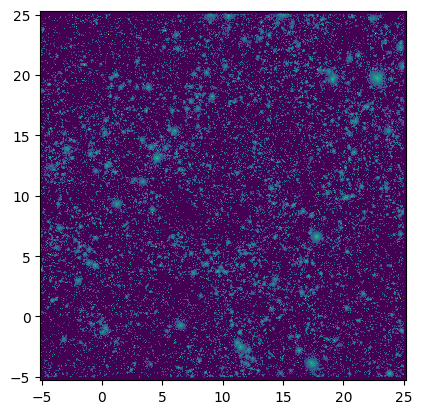

In [3]:
t_all = pd.DataFrame([])
for p in phlists:
    t = Table.read("../data/eROSITA_30.0x30.0/Phox/"+p, hdu=2)
    t_all = vstack([t_all, t])
    
plt.hist2d(t_all["RA"], t_all["DEC"], bins=2000, norm=matplotlib.colors.SymLogNorm(linthresh=1, linscale=1))
plt.gca().set_aspect('equal', 'box')
plt.show()

### Binning clusters:

In [4]:
geometry = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/geometry.dat", sep='\s+', header=2)

binned_clusters = {}
   
for borders in list(zip(geometry["z_start"], geometry["z_end"], geometry["zslice"], geometry["snapNr"])):
    
    for ind in clusters.index:

        zt = clusters.loc[ind]["z_true"]

        if zt > borders[0] and zt < borders[1]:

            binned_clusters[ind] = borders[2], str(borders[3])
                
#sorted(binned_clusters.items())

redshifts = [clusters.loc[i]["z_true"] for i in clusters.index]

geometry

,snapNr,ztab,zslice,z_start,z_end,x0,y0,z0,depth,width
0,144,0.001001,0.008625,0.000000,0.017281,230.604600,52.929941,38.137176,73.327162,21.167728
1,140,0.033671,0.033822,0.017281,0.050478,305.341400,149.855590,172.109480,139.387980,82.573299
2,136,0.067408,0.067555,0.050478,0.084760,97.871486,134.586170,117.805860,141.855220,163.761220
3,132,0.102245,0.102388,0.084760,0.120158,185.353850,229.067940,294.134880,144.222380,246.344710
4,128,0.138220,0.138357,0.120158,0.156713,146.337120,179.784950,264.241690,146.478010,330.262680
5,124,0.175368,0.175501,0.156713,0.194460,170.716390,187.570430,175.891600,148.610980,415.447530


### Catalogue of galaxies:

In [5]:
galaxies_all = pd.read_csv("../data/eROSITA_30.0x30.0/Catalouges/galaxies.dat", sep='\s+', header=0)
galaxies_all

,isub,x_pix,y_pix,z_pix,vmax,z_true,z_obs,Mstar,sfr,u,...,z,Y,J,H,K,L,M,Age,Z,flag
0,201683,0.962549,0.467828,-0.002068,482.064,0.156636,0.156890,43.348600,3.053100,-22.5014,...,-24.7014,-24.9937,-25.3885,-26.0246,-26.2821,-26.4280,-26.4574,0.269562,1.053180,1
1,294417,0.308135,0.547052,-0.001271,394.019,0.156666,0.158137,30.742500,0.000000,-21.9320,...,-24.3703,-24.6621,-25.0561,-25.6940,-25.9519,-26.0967,-26.1231,0.312990,1.006500,1
2,428854,0.239429,0.219663,-0.000989,316.786,0.156676,0.156816,16.174300,0.000000,-21.2007,...,-23.6519,-23.9443,-24.3406,-24.9775,-25.2325,-25.3763,-25.4013,0.316229,1.001770,1
3,260150,0.176925,0.999731,-0.000952,413.087,0.156678,0.155405,43.030700,0.000000,-22.2601,...,-24.7233,-25.0224,-25.4214,-26.0616,-26.3205,-26.4663,-26.4947,0.316437,1.050650,1
4,441383,0.756445,0.922726,-0.000933,259.644,0.156678,0.156527,9.024170,0.000000,-20.4671,...,-22.9383,-23.2374,-23.6374,-24.2763,-24.5329,-24.6785,-24.7070,0.267401,1.092940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632086,1638584,0.090051,0.010463,0.999554,119.088,0.050463,0.050948,0.256724,0.279066,-19.6446,...,-20.0053,-20.1091,-20.3440,-20.8969,-21.1480,-21.2692,-21.2597,0.617970,0.200753,0
632087,1417538,0.133690,0.629479,0.999680,124.889,0.050467,0.051280,0.365516,0.872128,-20.8601,...,-21.0364,-21.2277,-21.5090,-22.1232,-22.4427,-22.6011,-22.6442,0.760209,0.531133,0
632088,197071,0.984320,0.001112,0.999711,113.671,0.050468,0.046894,0.280967,1.032990,-19.3255,...,-20.9473,-21.1335,-21.3442,-22.0208,-22.4384,-22.6206,-22.6835,0.799404,0.305648,0
632089,1182914,0.523695,0.528769,1.000098,130.264,0.050481,0.051212,1.220900,0.532199,-20.7506,...,-21.8453,-22.1433,-22.5103,-23.1606,-23.4823,-23.6515,-23.7068,0.665157,0.810235,1


### Single cluster: pure ICM photons (no AGNs)

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
17964,83,0.362858,0.386705,0.992546,0.007788,2.471400e+14,0.119892,0.119569,1.200570e+14,632.238,4.273180e+12,1.064140e+13,2.30589,0.487051,0.000002,1.864380e+14,993.667,0


<Figure size 640x480 with 0 Axes>

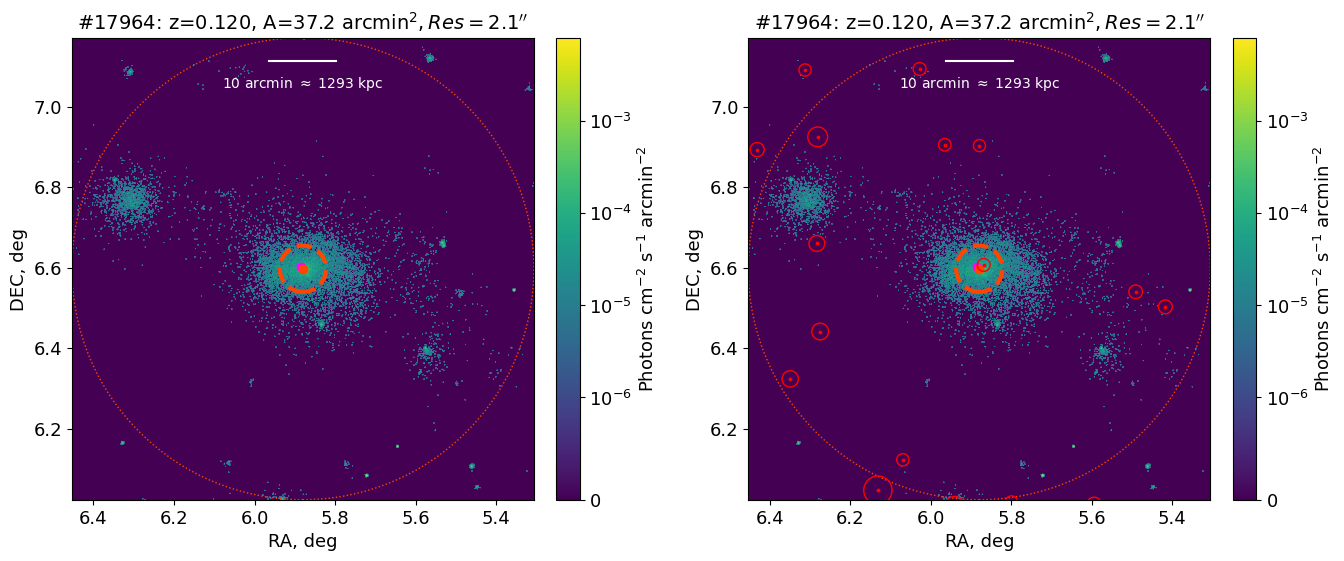

In [6]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(16,6))
plt.tight_layout()

cl_num = 17964

display(clusters[clusters.index==cl_num])

plt.subplot(121)
pho_hist1 = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=False, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

plt.subplot(122)
pho_hist2, msk = extract_photons_from_cluster(cl_num, 
                                        r = 1.0, 
                                        centroid=True, 
                                        delete_superfluous=True, 
                                        draw=True,
                                        histlen=2000,
                                        withagn=False, 
                                        ARF_weights=False)

#print(sum(pho_hist1.flatten()), sum(pho_hist2.flatten()))
#display(plist1, plist2)

plt.show()

### Drawing panels:

In [ ]:
%run -i 'utils/scripts.py'

draw_84_panels()

plt.savefig('panels.png', format='png', dpi=100, bbox_inches='tight')
plt.close()
plt.show()

  0%|          | 0/84 [00:00<?, ?it/s]

#### This is 2d histogram of all the photons in $20 R_{500} \times 20 R_{500}$ field. To each bin of histogram correspond the number of photons in it, which then is divided by 1000 cm$^2$, 10000 s and area of bin (which varies from cluster to cluster because every image has 2000 pixels in length) to obtain the flux in corresponding units.

### Filtering of images:

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

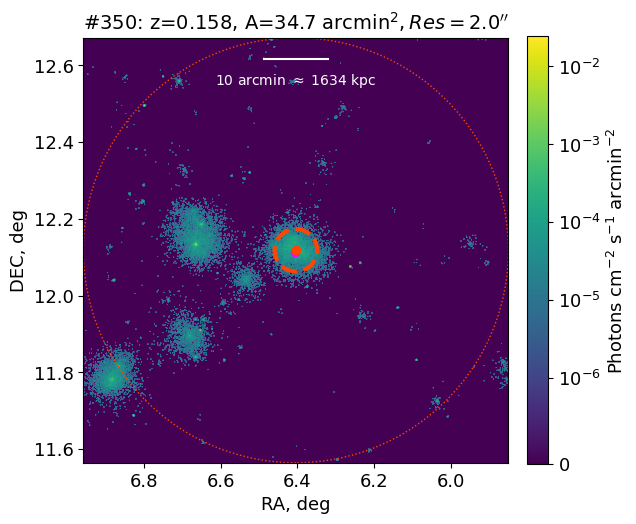

In [6]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

cl_num = 350

display(clusters[clusters.index==cl_num])

tyty0 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001, 
                                     ARF_weights=False)

plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

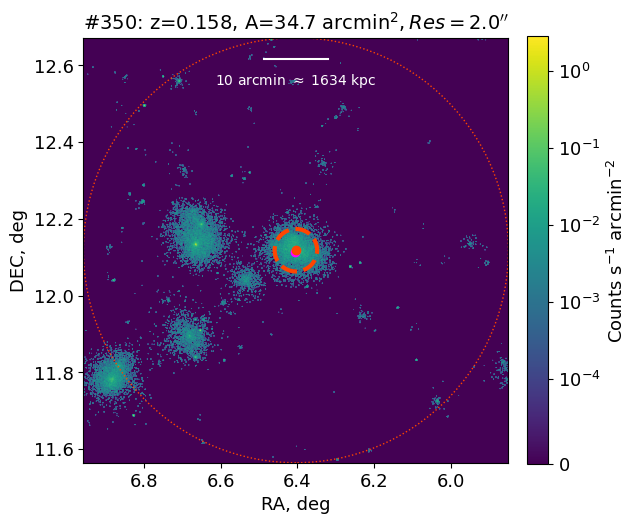

In [7]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty1 = extract_photons_from_cluster(cl_num,
                                     delete_superfluous=False, 
                                     draw=True,
                                     histlen=2001,
                                     ARF_weights=True)
plt.show()

,ihal,x_pix,y_pix,z_pix,Rrel,Mvir,z_true,z_obs,M500,R500,Mstar500,Mgas500,T500,Lx500,Ysz500,M200,R200,flag
350,77,0.380183,0.570491,0.0338,0.005197,3.282700e+14,0.157977,0.15781,1.925340e+14,771.351,5.156740e+12,2.121000e+13,3.21771,1.51569,0.000005,2.887220e+14,1198.27,0


<Figure size 640x480 with 0 Axes>

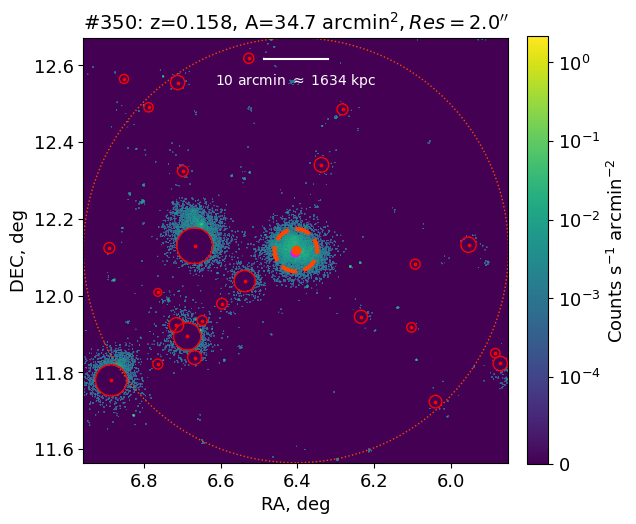

In [8]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

display(clusters[clusters.index==cl_num])

tyty2, msk = extract_photons_from_cluster(cl_num, 
                                          delete_superfluous=True, 
                                          draw=True,
                                          histlen=2001,
                                          ARF_weights=True)
plt.show()

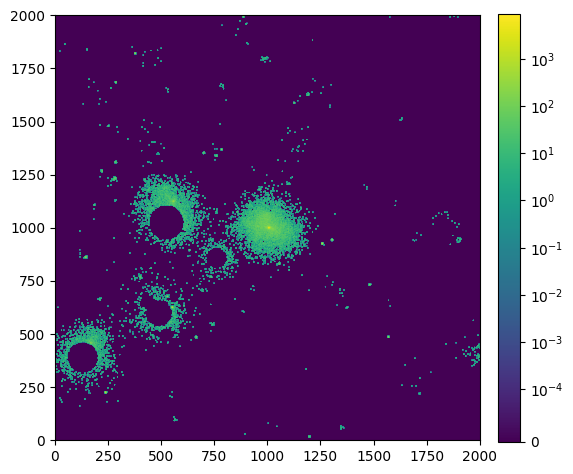

In [9]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(tyty2*(msk))), origin='lower', norm=matplotlib.colors.SymLogNorm(linthresh=0.0001, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

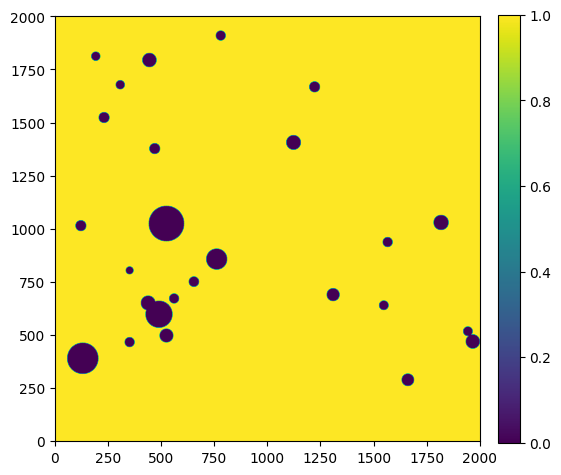

In [10]:
plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(msk)), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

<Figure size 640x480 with 0 Axes>

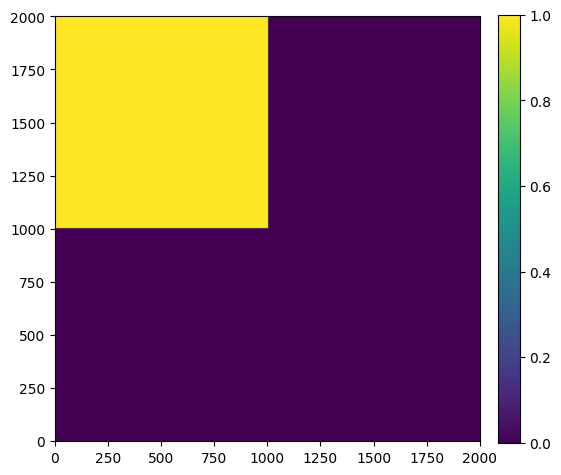

In [11]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6,6))

plt.imshow(np.rot90(np.flip(wedge(4, 2001))), origin='lower')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

### Calculating brightness profile for one cluster (which is above):

Original:

  0%|          | 0/23 [00:00<?, ?it/s]

[0.0011525557929629815, 0.0015204652283521498, 0.002538603492258981, 0.0031415274670260574, 0.0028612717422399035, 0.0011758667688816626, 0.0004175885643961935, 0.0002323389152399436, 0.00016429065373159868, 0.00013596696018243834, 0.00012741654576805953, 0.00010315450700131419, 8.028052790323127e-05, 4.442888715645954e-05, 2.3296772185938217e-05, 7.93736855810945e-06, 2.347072637356462e-06, 6.00689849147515e-07, 1.458653525953872e-06, 1.4772802762860355e-06, 3.1380393686538717e-06, 8.119384829971483e-07, 3.5257607657013084e-07] [0.0006420727132265432, 0.0012669673311336217, 0.0026802569207602825, 0.004115835721259138, 0.003907417901290248, 0.0013067140992645049, 0.00028116537966737, 7.941464471328997e-05, 3.2051178522982023e-05, 3.653361351285236e-05, 2.7018467894063105e-05, 2.464203658164786e-05, 2.1429994026032616e-05, 1.1468721988813669e-05, 6.582371942605037e-06, 2.6794005859611364e-06, 7.596828881406872e-07, 5.538465242857689e-07, 1.3838543008595161e-06, 1.6501570194660739e-06, 4

<Figure size 640x480 with 0 Axes>

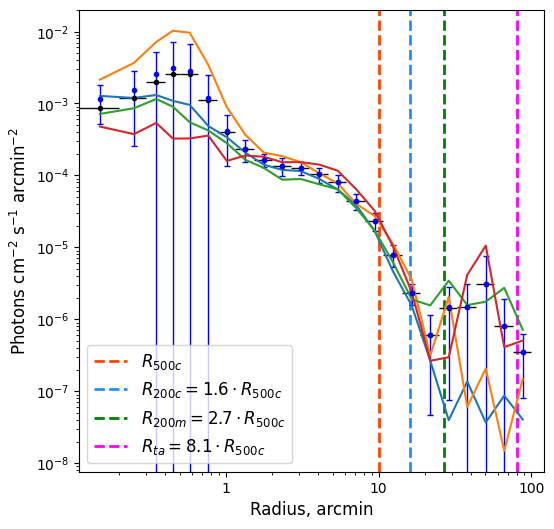

In [12]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=tyty0,
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=False)

plt.show()

  0%|          | 0/23 [00:00<?, ?it/s]

[0.1055187791616681, 0.13670485439384578, 0.22471415913763504, 0.27180089570625154, 0.277183814028701, 0.1234022032883024, 0.04648114144205183, 0.02705427183115894, 0.02015048609123924, 0.015926057176365874, 0.014790770567265386, 0.012076774189170365, 0.009403534687963396, 0.0051417607923757574, 0.0026359574053797714, 0.0009102007067302079, 0.0002658537240177142, 6.706334018161412e-05, 0.00015585760370010021, 0.00016078522829458242, 0.00035706850748377434, 8.938275485510477e-05, 3.6835509527933106e-05] [0.06245950172810358, 0.1085966927437063, 0.22006204081290473, 0.36383424099465655, 0.3786764692784288, 0.12983812266116546, 0.0339039005958918, 0.009724369084502768, 0.004857927307299694, 0.004650310821025732, 0.0028177601482660556, 0.002968708571151871, 0.0025942632357246758, 0.0013548084898652752, 0.0007512222762514752, 0.0003086466848644889, 8.931727672480155e-05, 6.366082139825965e-05, 0.0001559985408195595, 0.00018159007867406225, 0.0004946909374873332, 0.0001246309651810892, 3.000

<Figure size 640x480 with 0 Axes>

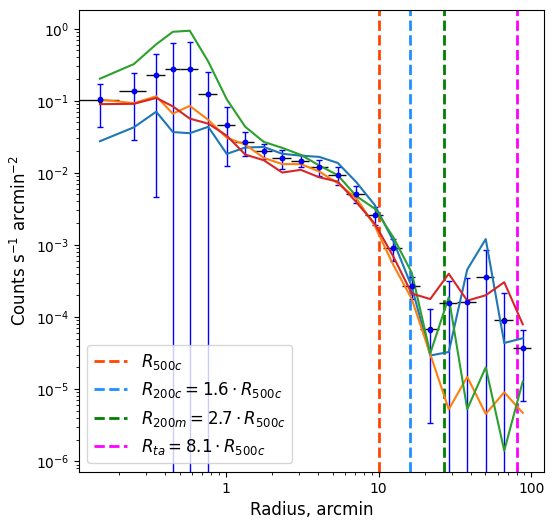

In [13]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(tyty1),
                          mmmask='no',
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

Filtered:

In [ ]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=np.rot90(np.flip(tyty2)),
                          mmmask=np.rot90(np.flip(msk)),
                          field_length=20,
                          draw=True,
                          ARF_weights=True)

plt.show()

### Calculating profiles for each cluster:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=False,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(hist=pho_hist,
                              mmmask='no',
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-original.csv', sep=' ', header=False, index=True)

In [92]:
yarkosti = pd.read_csv("brpr-original.csv", sep='\s+', header=None, index_col=0)
yarkosti.index=np.array(clusters.index[:])
display(yarkosti)
yarkosti = yarkosti.to_numpy()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
171,1.100628,1.538938,1.493736,1.185996,0.917406,0.635862,0.319347,0.192474,0.111875,0.076461,...,0.011150,0.006009,0.002579,0.000878,0.000227,3.979019e-05,2.150265e-05,6.574643e-05,1.351000e-04,1.627697e-04
187,0.161579,0.140519,0.096394,0.141284,0.133617,0.240524,0.365524,0.114539,0.041910,0.026266,...,0.005762,0.003769,0.002666,0.000933,0.000299,1.279758e-04,3.087739e-04,1.404233e-03,3.980953e-04,2.572256e-04
350,0.091494,0.103170,0.136513,0.224232,0.272761,0.276353,0.123283,0.046518,0.026968,0.020140,...,0.005141,0.002636,0.000910,0.000266,0.000067,1.560725e-04,1.608499e-04,3.571303e-04,8.945323e-05,3.684899e-05
820,0.048555,0.043425,0.057930,0.082135,0.092737,0.089660,0.103656,0.205771,0.130356,0.075556,...,0.009395,0.005303,0.003179,0.000870,0.000174,8.182431e-05,7.917636e-05,1.105809e-05,2.841036e-05,9.374194e-05
1245,0.075548,0.173666,0.166429,0.363123,0.473390,0.666072,0.917639,0.415432,0.096811,0.062267,...,0.010851,0.006329,0.002788,0.001457,0.000445,5.610143e-05,8.381909e-05,2.234274e-04,7.678749e-05,3.141511e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,0.001243,0.001126,0.001260,0.001689,0.001380,0.001282,0.001485,0.001885,0.001950,0.001358,...,0.000440,0.000278,0.000149,0.000105,0.000029,6.549651e-06,9.549755e-06,1.123191e-05,6.670677e-06,2.229695e-06
18610,0.000427,0.000703,0.000608,0.000443,0.000409,0.000499,0.000433,0.000511,0.000442,0.000531,...,0.000949,0.000194,0.000102,0.000052,0.000020,5.517159e-06,1.110309e-06,1.505490e-06,1.836270e-06,5.031328e-06
19523,0.007765,0.007644,0.006744,0.003831,0.004498,0.003983,0.008453,0.018804,0.054443,0.016981,...,0.001446,0.001081,0.000628,0.000337,0.000173,7.251720e-05,2.221944e-05,3.382695e-05,3.894318e-05,2.336218e-06
19771,0.000474,0.000504,0.000613,0.000744,0.000932,0.001246,0.001463,0.000535,0.000299,0.000238,...,0.000026,0.000014,0.000007,0.000002,0.000001,1.935449e-07,1.194111e-07,2.839977e-08,2.854644e-08,5.182988e-08


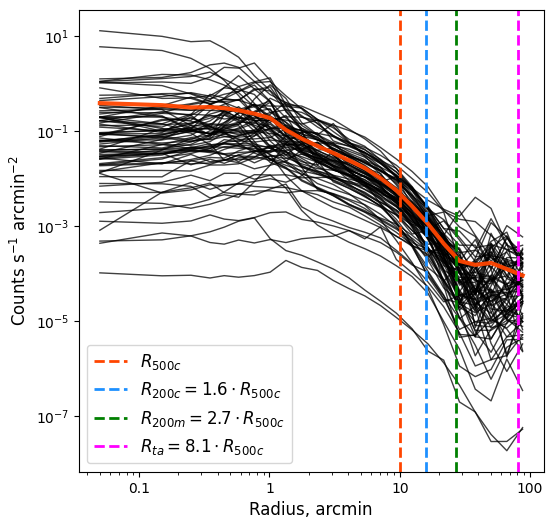

In [30]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[8])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/84, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [76]:
%run -i 'utils/scripts.py'

length = 2001

total_hist_unfiltered = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=False, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_unfiltered = np.add(total_hist_unfiltered, pho_hist)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

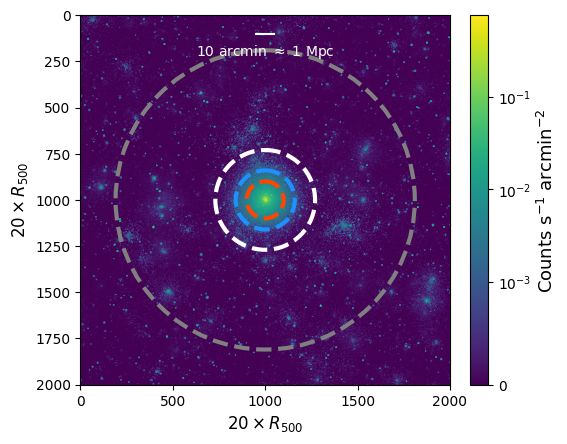

In [77]:
half_length = int(length/2)
r500r = int(half_length/10)

plt.imshow(np.rot90(total_hist_unfiltered/84), norm=matplotlib.colors.SymLogNorm(linthresh=0.001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=3, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=3, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

In [90]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=total_hist_unfiltered/84,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True)

plt.ylim(1e-8, 2e1)

plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')
plt.legend(loc=3, fontsize=12)

plt.show()

NameError: name 'total_hist_unfiltered' is not defined

<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

### And now the same for filtered images:

In [ ]:
%run -i 'utils/scripts.py'

df_all = pd.DataFrame()

for cl_num in tqdm(clusters.index[:84]):

    pho_hist, mmaasskk = extract_photons_from_cluster(cl_num, 
                                            delete_superfluous=True,
                                            draw=False,
                                            histlen=2001,
                                            ARF_weights=True)

    brbr = brightness_profile(hist=pho_hist,
                              mmmask=mmaasskk,
                              field_length=20,
                              draw=False)
    
    df_add = pd.DataFrame(brbr).T      
    df_all = pd.concat([df_all, df_add], axis=0)
    
    df_all.to_csv('brpr-masked.csv', sep=' ', header=False, index=True)

In [83]:
np.array(clusters.index[:])

array([  171,   187,   350,   820,  1245,  1380,  1707,  1819,  1838,
        2270,  2386,  2421,  2471,  2593,  2603,  2815,  2904,  3155,
        3886,  3985,  4613,  4967,  5326,  5443,  6001,  6496,  6529,
        6582,  6695,  6740,  7191,  7308,  7364,  7409,  7553,  7996,
        8211,  8930,  9240,  9389,  9636,  9836, 10018, 10548, 10551,
       10820, 10842, 10928, 11141, 11272, 11428, 11468, 11599, 11847,
       12045, 12296, 13334, 13675, 13751, 14038, 14434, 14559, 14660,
       14667, 14726, 14857, 14936, 15138, 16666, 17017, 17086, 17174,
       17365, 17415, 17421, 17638, 17654, 17964, 18073, 18589, 18610,
       19523, 19771, 19787])

In [100]:
yarkosti = pd.read_csv("brpr-masked.csv", sep='\s+', header=None, index_col=0)
yarkosti.index=np.array(clusters.index[:])
yarkosti = yarkosti.loc[yarkosti.index.isin(w)]
print(len(yarkosti))
display(yarkosti)
yarkosti = yarkosti.to_numpy()

31


,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
350,0.091494,0.103170,0.136513,0.224232,0.272761,0.276353,0.123283,0.046518,0.026968,0.020140,...,0.005141,0.002636,0.000910,0.000266,0.000058,8.152420e-05,9.997049e-05,1.160876e-04,4.438273e-05,2.441727e-05
820,0.048555,0.043425,0.057930,0.082135,0.092737,0.089660,0.103656,0.205771,0.130356,0.075556,...,0.009395,0.005303,0.003179,0.000870,0.000174,8.168712e-05,7.878826e-05,7.718388e-06,1.859727e-05,6.285754e-05
1707,0.026880,0.020156,0.031755,0.022258,0.024800,0.024868,0.025333,0.029538,0.025958,0.032237,...,0.006356,0.003439,0.001326,0.000533,0.000111,1.575518e-05,1.825951e-06,6.676761e-06,7.043723e-06,3.203562e-05
1819,0.029019,0.032824,0.038069,0.034777,0.031623,0.029354,0.028807,0.023702,0.036336,0.023686,...,0.003510,0.001816,0.000789,0.000408,0.000386,3.399480e-04,7.970935e-05,1.470923e-05,4.240233e-06,8.199986e-06
2270,0.014627,0.014591,0.014210,0.019016,0.019044,0.020180,0.027473,0.050324,0.035763,0.017350,...,0.002577,0.001161,0.000369,0.000085,0.000028,2.346550e-05,7.969162e-06,4.936834e-06,1.211608e-05,9.244425e-06
2421,0.060516,0.082538,0.105035,0.112729,0.148933,0.232244,0.357948,0.277312,0.147581,0.073953,...,0.012673,0.004092,0.001811,0.000546,0.000123,1.645110e-05,3.857930e-05,7.492812e-05,1.325562e-05,4.722515e-05
2471,0.026397,0.033146,0.044638,0.045879,0.045031,0.042842,0.042617,0.036431,0.038666,0.043926,...,0.002898,0.001066,0.000441,0.000320,0.000056,4.454925e-06,4.739974e-06,1.207286e-05,1.016337e-05,6.575959e-06
2603,0.046167,0.050937,0.072113,0.080632,0.117772,0.097406,0.052605,0.031814,0.021445,0.017072,...,0.002527,0.001139,0.000389,0.000110,0.000035,5.132712e-06,4.836009e-06,9.207818e-06,4.098769e-06,1.086399e-05
3985,0.057719,0.075990,0.095818,0.087878,0.097812,0.082621,0.094347,0.110879,0.114138,0.077544,...,0.009145,0.004511,0.001386,0.000305,0.000216,5.894298e-05,5.370321e-05,3.029997e-05,2.522999e-05,2.875071e-05
4613,0.192844,0.111338,0.089347,0.050314,0.055512,0.079206,0.090029,0.184333,0.091525,0.052571,...,0.007917,0.004616,0.001965,0.000804,0.000377,9.868890e-05,7.078033e-05,6.025592e-05,2.129811e-04,1.205422e-04


<Figure size 640x480 with 0 Axes>

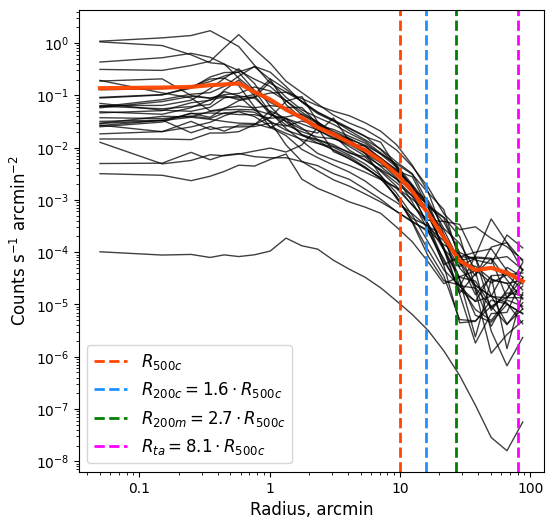

In [102]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

r_pixels_max = 1000 # 5*r500r    # depends on field size
r500r = int(r_pixels_max/10)
setka_bins = np.append([0, 1, 2, 3, 4],np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]  # centers of bins
err = np.diff(setka_bins)/2

yar = np.array(yarkosti[0])*0

#yarkosti = 

for i in range(0, len(yarkosti[::])):

    one = yarkosti[i]
    
    if one[0]==0 or one[1]==0:
        #print(one)
        llww=0
    else:
        llww=1
    
    yar = yar + one
    
    if one[-1]==np.nan:
        llww=10
        
    plt.plot(np.array(setka)/r500r*(10*998/1000), 
             np.array(one), 
             linewidth=llww, marker='.', markersize=0, alpha=0.75,
             color='black')
    
plt.plot(np.array(setka)/r500r*(10*998/1000), 
         np.array(yar)/31, 
         linewidth=3, marker='.', 
         markersize=0, alpha=0.95,
         color='orangered')

#plt.errorbar(np.array(setka)/r500r*(10*998/1000), 
#             np.array(yar)/84, 
#             xerr=err/r500r*(10*998/1000), 
#             linewidth=0, marker='.', 
#             markersize=3, alpha=0.95,
#             elinewidth=1, capsize=0, color='orangered')

plt.xlabel("Radius, arcmin", fontsize=12)  # "Radius in units of $R_{500}$")
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12) # "Brightness in relative units")

plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=2)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=2)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=2)

#plt.ylim(1e-8, 4e-2)
    
plt.legend(loc=3, fontsize=12)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])
plt.gca().set_aspect('auto', 'box')

In [9]:
%run -i 'utils/scripts.py'

length = 2001

total_hist_masked = np.zeros((length, length))
total_mask = np.zeros((length, length))

for cl_num in tqdm(clusters.index[:84]):
     
    pho_hist, mskk = extract_photons_from_cluster(cl_num,
                                            draw=False, 
                                            delete_superfluous=True, 
                                            histlen=2001, 
                                            ARF_weights=True)
    
    total_hist_masked = np.add(total_hist_masked, pho_hist*mskk)
    total_mask = np.add(total_mask, mskk)

  0%|          | 0/84 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

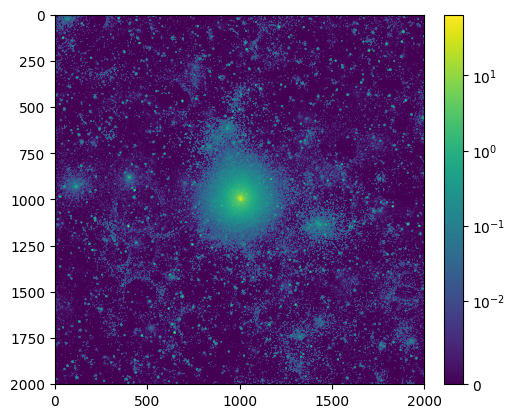

In [12]:
plt.imshow(np.rot90(total_hist_masked), norm=matplotlib.colors.SymLogNorm(linthresh=0.01, linscale=1))
plt.colorbar(fraction=0.046, pad=0.04)

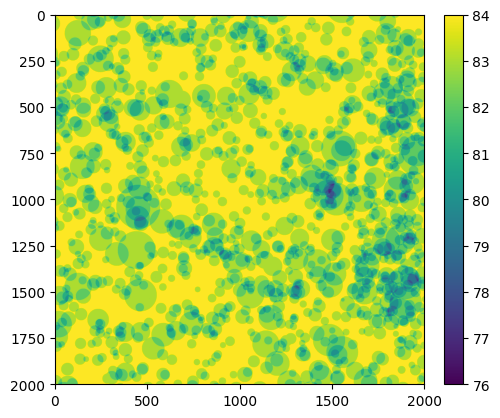

In [13]:
#total_mask[total_mask > 1] = True

plt.imshow(np.rot90(total_mask))
plt.colorbar(fraction=0.046, pad=0.04)

In [14]:
reduced_hist = np.divide(total_hist_masked, total_mask)

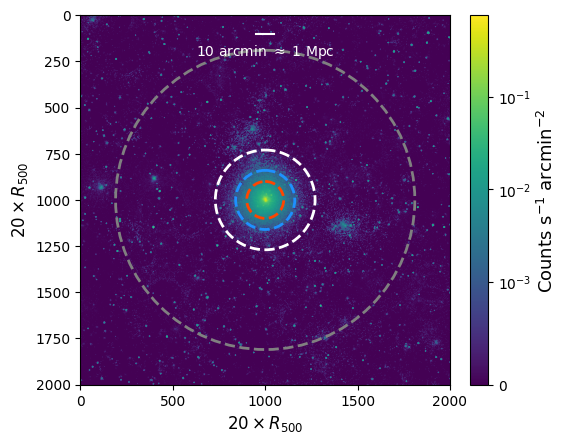

In [15]:
half_length = int(length/2)
r500r = int(half_length/10)

#mask_rescaled = 

plt.imshow(np.rot90(reduced_hist), norm=matplotlib.colors.SymLogNorm(linthresh=0.001, linscale=1), 
           origin='upper')
cb = plt.colorbar(fraction=0.046, pad=0.04)
cb.set_label(f"Counts s$^{{-1}}$ arcmin$^{{-2}}$", size=13)

plt.gca().add_patch(plt.Circle((half_length, half_length), r500r, 
                               color='orangered', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*1.6, 
                               color='dodgerblue', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*2.7, 
                               color='white', linestyle="--", lw=2, fill = False))
plt.gca().add_patch(plt.Circle((half_length, half_length), r500r*8.1, 
                               color='grey', linestyle="--", lw=2, fill = False))

x_s = (plt.gca().get_xlim()[1]+plt.gca().get_xlim()[0])/2
y_s = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.95+plt.gca().get_ylim()[0]
y_S = (plt.gca().get_ylim()[1]-plt.gca().get_ylim()[0])*0.90+plt.gca().get_ylim()[0]   
plt.plot((x_s+r500r/2, x_s-r500r/2), (y_s, y_s), color='white')
plt.text(x_s, y_S, f'10 arcmin $\\approx$ 1 Mpc', 
         color='white', ha='center', va='center')

plt.xlabel("$20 \\times R_{500}$", fontsize=12)
plt.ylabel("$20 \\times R_{500}$", fontsize=12)

plt.show()

  0%|          | 0/24 [00:00<?, ?it/s]

/home/aleksei/work/clusters/stacking/utils/scripts.py:435: RuntimeWarning: invalid value encountered in scalar divide
  brw2 = (hist*cw).sum()/sum(cw.flatten())


<Figure size 640x480 with 0 Axes>

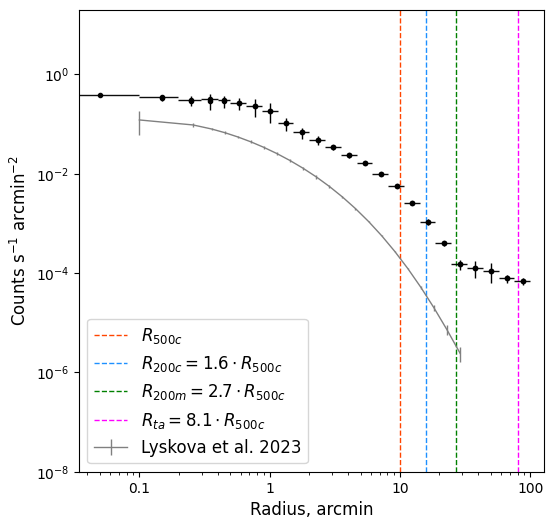

In [54]:
%run -i 'utils/scripts.py'

plt.figure(figsize=(6, 6))

brbr = brightness_profile(hist=reduced_hist,
                          mmmask='no',
                          draw=True,
                          field_length=20,
                          ARF_weights=True,
                          errors=True)

plt.ylim(1e-8, 20)

plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1, color='grey', label='Lyskova et al. 2023')
plt.legend(loc=3, fontsize=12)

plt.show()

In [33]:
def beta_model_surface_brightness(r, S0, rc, beta):
    
    return S0 * (1 + (r / rc)**2)**(-3 * beta / 2)

In [34]:
true_S0 = 1.0
true_rc = 0.5
true_beta = 2/3

In [50]:
# Fit the beta model to the noisy data
initial_guess = [1.0, 0.5, 0.67]  # Initial guess for S0, rc, beta
popt, pcov = curve_fit(beta_model_surface_brightness, rr, np.array(brbr), p0=initial_guess)

In [51]:
# Extract fitted parameters
fitted_S0, fitted_rc, fitted_beta = popt
print(f"Fitted parameters: S0 = {fitted_S0}, rc = {fitted_rc}, beta = {fitted_beta}")

Fitted parameters: S0 = 0.3594146936426113, rc = 1.0284172727119074, beta = 0.7327477302945958


In [52]:
# Generate fitted values for plotting
S_fitted = beta_model_surface_brightness(rr, *popt)

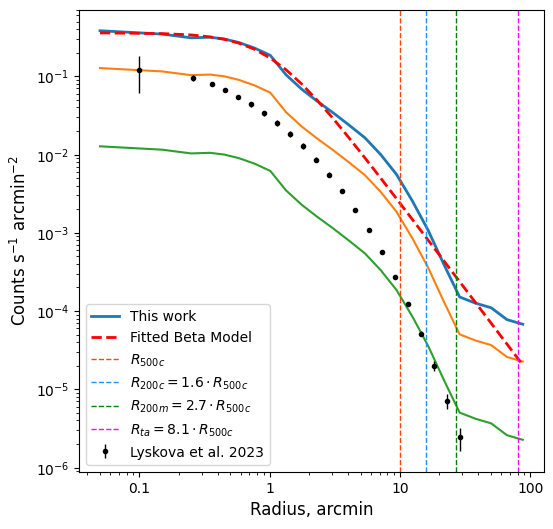

In [58]:
setka_bins = np.append([0, 1, 2, 3, 4], np.geomspace(5, r_pixels_max, 20))
setka = [(a+b)/2 for a, b in zip(setka_bins[:-1], setka_bins[1:])]
rr = np.array(setka)/r500r*(10*998/1000)

plt.figure(figsize=(6, 6))

plt.plot(rr, np.array(brbr), label='This work', lw=2)
plt.plot(rr, np.array(brbr)/3.) # np.geomspace(2.3, 0.1*r_pixels_max, 24))
plt.plot(rr, np.array(brbr)/30)
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=0, elinewidth=1, markersize=3, marker='o', color='black', label='Lyskova et al. 2023')

plt.plot(rr, S_fitted, label='Fitted Beta Model', color='red', ls='--', lw=2)

plt.xlabel("Radius, arcmin", fontsize=12)
plt.ylabel("Counts s$^{{-1}}$ arcmin$^{{-2}}$", fontsize=12)
plt.xscale("log")
plt.yscale("log")

plt.axvline(10*998/1000, linestyle='--', color='orangered', label='$R_{500c}$', lw=1)
plt.axvline(10*998/1000*1.6, linestyle='--', color='dodgerblue', label='$R_{200c} = 1.6 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*2.7, linestyle='--', color='green', label='$R_{200m} = 2.7 \cdot R_{500c}$', lw=1)
plt.axvline(10*998/1000*8.1, linestyle='--', color='magenta', label='$R_{ta} = 8.1 \cdot R_{500c}$', lw=1)

plt.legend(loc=3, fontsize=10)
plt.xticks([0.1, 1, 10, 100], [0.1, 1, 10, 100])

plt.show()

### Natalya's profile:

In [17]:
Ix = pd.read_csv("sb_fig3_errorbars.dat", sep='\s+', header=None)
display(Ix)
#yarkosti = yarkosti.to_numpy()

,0,1,2,3
0,0.100019,0.120754,0.061235,0.180273
1,0.258809,0.095725,0.087513,0.103937
2,0.358865,0.079372,0.074380,0.084363
3,0.452170,0.067034,0.062723,0.071345
4,0.569734,0.054965,0.051957,0.057972
5,0.717865,0.043767,0.040844,0.046690
6,0.904510,0.033826,0.031296,0.036357
7,1.139680,0.025341,0.023278,0.027405
8,1.436000,0.018363,0.016830,0.019895
9,1.809360,0.012834,0.011799,0.013868


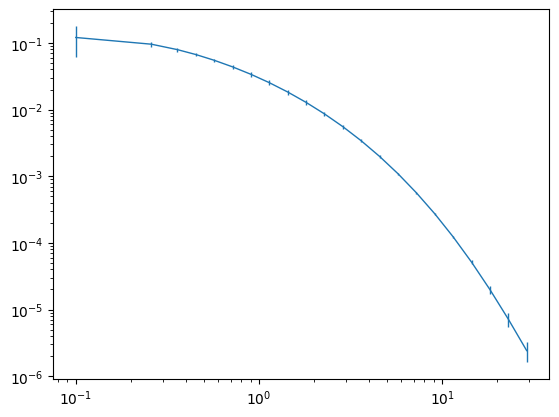

In [18]:
plt.errorbar(Ix[0], Ix[1], (Ix[3]-Ix[1], Ix[1]-Ix[2]), lw=1)
plt.xscale("log")
plt.yscale("log")

In [59]:
SMPL = pd.read_csv("sample.dat", sep='\s+', header=0)
display(SMPL)

,Name,M500c(10^14*M_sun),R500c(kpc),z
0,G028.89+60.13,4.47,1133.8,0.1530
1,G031.93+78.71,2.72,973.8,0.0724
2,G033.81+77.18,4.46,1150.2,0.0622
3,G040.03+74.95,2.34,927.8,0.0612
4,G040.58+77.12,2.57,955.2,0.0748
5,G041.45+29.10,5.41,1203.1,0.1780
6,G042.81+56.61,4.22,1127.4,0.0723
7,G044.20+48.66,8.77,1434.7,0.0894
8,G046.88+56.48,5.10,1192.5,0.1145
9,G048.10+57.16,3.54,1062.3,0.0777


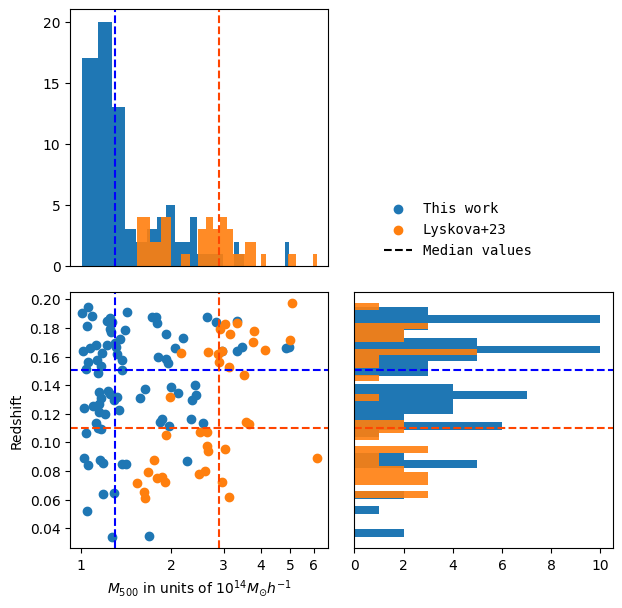

In [80]:
plt.figure(figsize = (7,7))

plt.subplot(221)

plt.hist(clusters["M500"]/10**14, bins=30, histtype='stepfilled')
plt.hist(SMPL["M500c(10^14*M_sun)"]*0.7, bins=30, histtype='stepfilled', alpha=0.9)
#plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
#plt.xticks([])
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.7), linestyle='--', color='orangered')
plt.xscale("log")
#plt.xticks([1,2,3,4,5], [1,2,3,4,5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.yticks([0,5,10,15,20], [0,5,10,15,20])

plt.subplot(224)

plt.hist(clusters["z_true"], bins=30, histtype='stepfilled', orientation="horizontal")
plt.hist(SMPL["z"], bins=30, histtype='stepfilled', orientation="horizontal", alpha=0.9)
#plt.xlabel("Redshift $z_{true}$")
plt.yticks([])
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orangered')

plt.subplot(223)

plt.scatter(clusters["M500"]/10**14, clusters["z_true"], label='This work')
plt.scatter(SMPL["M500c(10^14*M_sun)"]*0.7, SMPL["z"], label='Lyskova+23')
plt.ylabel("Redshift")
plt.xlabel("$M_{500}$ in units of $10^{14} M_{\odot} h^{-1}$")
plt.xscale("log")
plt.xticks([1,2,3,4,5,6], [1,2,3,4,5,6])
#plt.yscale("log")
plt.axvline(np.median(clusters["M500"]/10**14), linestyle='--', color='blue')
plt.axhline(np.median(clusters["z_true"]), linestyle='--', color='blue')
plt.axvline(np.median(SMPL["M500c(10^14*M_sun)"]*0.7), linestyle='--', color='orangered')
plt.axhline(np.median(SMPL["z"]), linestyle='--', color='orangered')
plt.plot([], [], linestyle='--', color='black', label="Median values")

plt.legend(fontsize=15, prop={'family': 'monospace'},
           frameon=False,
           loc='upper center', bbox_to_anchor=(1.5, 1.4),
           fancybox=True, shadow=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('figures/histogram_84.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [81]:
min(SMPL["M500c(10^14*M_sun)"]*0.7)

1.54

### Uploading $eROSITA$'s ARF (for one TM, but $\times 7$):

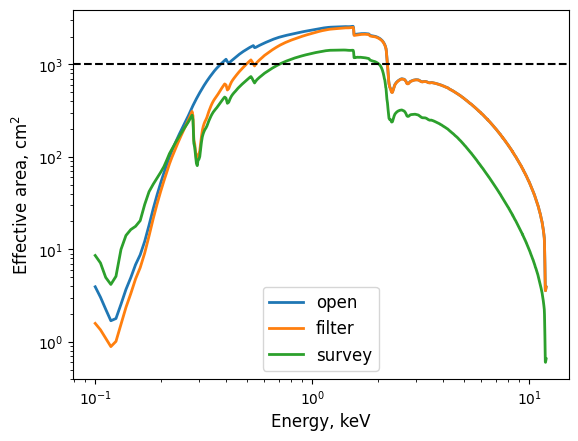

In [51]:
arf_open = fits.open('../erosita/tm1_arf_open_000101v02.fits')[1].data
arf_filter = fits.open('../erosita/tm1_arf_filter_000101v02.fits')[1].data
arf_survey = fits.open('../erosita/esf10.Dsur1234regR3cCaXv2.0001.arf')[1].data

plt.plot(arf_open["ENERG_LO"], 7*arf_open["SPECRESP"], label='open', lw=2)
plt.plot(arf_filter["ENERG_LO"], 7*arf_filter["SPECRESP"], label='filter', lw=2)
plt.plot(arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"], label='survey', lw=2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel('Energy, keV', fontsize=12)
plt.ylabel('Effective area, cm$^2$', fontsize=12)
plt.legend(loc=8, fontsize=12)

plt.axhline(1000, ls='--', color='k')

plt.show()

In [61]:
T = Table(arf_survey)[np.where( (arf_survey["ENERG_LO"]>0.3) & (arf_survey["ENERG_HI"]<2.3))]
np.mean(T["SPECRESP"])

137.29648

#### The arf for 'survey' is taken (i.e. FoV averaged). Dashed line indicates flat effective area for pure photons.

In [191]:
sl = plist
#sl["FLUX"] = sl["ENERGY"] / 1000 / 10000 / 4**2 * 60**2      # keV/cm2/s/arc
sl["EFF_AREA"] = np.interp(sl["ENERGY"], arf_survey["ENERG_LO"], 7*arf_survey["SPECRESP"]) # cm2
#sl["RATE"] = sl["FLUX"] * sl["EFF_AREA"]    # keV/s

In [193]:
display(sl)

,ENERGY,RA,DEC,EFF_AREA
184785,0.323053,21.348543,20.766006,203.626375
184786,0.343827,21.355482,20.772743,284.265233
184787,0.555965,21.371180,20.770899,682.122756
185727,0.337027,20.876253,20.296146,257.816883
186381,0.543377,22.289717,20.704340,634.104344
...,...,...,...,...
6341113,0.942630,22.602350,18.439213,1276.137104
6341114,1.006420,22.615623,18.453289,1322.000349
6341115,1.149363,22.614796,18.460176,1404.864806
6341116,1.807550,22.611002,18.448803,1162.806014
